In [1]:
from PIL import Image
import cv2
import torch
import math 
from IPython.display import display #display PIL image
import os
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

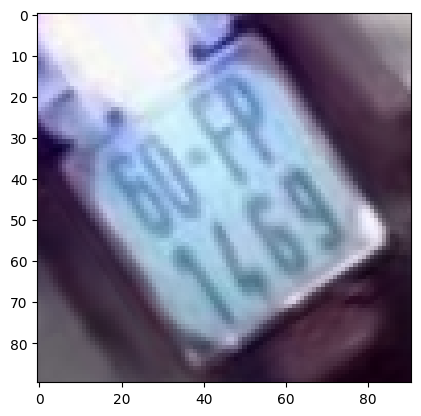

In [2]:
# read image
img1 = cv2.imread('test_image/23.png')
plt.imshow(img1)

In [3]:
def ShowImage(ImageList, nRows=1, nCols=2, WidthSpace=0.00, HeightSpace=0.00):
    """
    Display a list of images in a grid layout using Matplotlib.

    Parameters:
        ImageList (list): List of images to be displayed.
        nRows (int): Number of rows in the grid layout. Default is 1.
        nCols (int): Number of columns in the grid layout. Default is 2.
        WidthSpace (float): Horizontal space between grid cells. Default is 0.00.
        HeightSpace (float): Vertical space between grid cells. Default is 0.00.
    """
    # Initialize a GridSpec object for the grid layout with specified rows and columns
    gs = gridspec.GridSpec(nRows, nCols)

    # Update the grid spacing with the provided width and height spacing
    gs.update(wspace=WidthSpace, hspace=HeightSpace)  # Adjust spacing between plots.

    # Set the figure size
    plt.figure(figsize=(20, 10))

    # Loop through the list of images
    for i in range(len(ImageList)):
        # Create a subplot for the current image using GridSpec
        ax1 = plt.subplot(gs[i])

        # Remove tick labels for a cleaner display
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

        # Set the aspect ratio to 'equal' to preserve image dimensions
        ax1.set_aspect('equal')

        # Create another subplot using standard indexing
        plt.subplot(nRows, nCols, i + 1)

        # Copy the image to avoid modifying the original
        image = ImageList[i].copy()

        # Check if the image is grayscale (2D array)
        if len(image.shape) < 3:
            # Display grayscale image using the appropriate colormap
            plt.imshow(image, plt.cm.gray)
        else:
            # Display color image
            plt.imshow(image)

        # Add a title to the image, e.g., "Image 0", "Image 1", etc.
        plt.title("Image " + str(i))

        # Turn off axes for a cleaner display
        plt.axis('off')

    # Show all the images
    plt.show()

**màu LAB:**
- L (Lightness): độ sáng của màu, nhận giá trị từ 0 (màu đen) đến 100 (màu trắng)
- A (green-red component): thành phần màu từ xanh lá cây đến đỏ, nhận giá trị từ -128 (màu xanh lá) đến 127 (màu đỏ)
- B (Blue-yellow component): thành phần màu từ xanh dương đến vàng, nhận giá trị từ -128 (màu xanh dương) đến 127 (màu vàng)

chuyển sang màu LAB để chỉnh độ tương phản không ảnh hưởng đến màu sắc. 

**CLAHE:** chia hình ảnh thành các ô lưới nhỏ hơn (tiles) và thực hiện cân bằng histogram trên từng ô lưới      
- Cải thiện độ tương phản cục bộ trong từng vùng của ảnh.
- Giới hạn độ tương phản (clipLimit): để ngăn chặn việc tăng cường quá mức độ tương phản, clipLimit càng cao thì cho phép tăng độ tương phản nhiều hơn.
- tileGridSize: kích thước của cái ô (tiles) mà CLAHE áp dụng.


In [4]:
def changeContrast(img):
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB) # convert from BGR to LAB 
    l_channel, a, b = cv2.split(lab) # tach cac kenh mau
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8)) # tao doi tuong CLAHE
    cl = clahe.apply(l_channel) # ap dung CLAHE vao kenh L
    limg = cv2.merge((cl,a,b)) # merge lai cac kenh mau
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR) # convert from LAB to BGR
    return enhanced_img

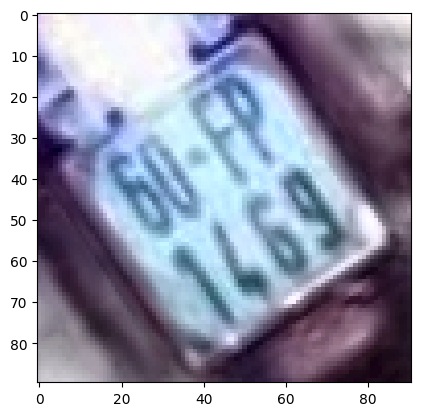

In [5]:
plt.imshow(changeContrast(img1))

**MedianBlur:** khử nhiễu hoặc làm mờ ảnh, input: ảnh đầu vào và kernel size.       
Khử nhiễu để Canny edge detection hoạt động tốt hơn. Do Canny là phương pháp đạo hàm cấp 2 trong edge detection.

**Canny:** phương pháp edge detection và tăng độ sáng cho cạnh được tìm thấy
- threshold1: ngưỡng dưới để phát hiện cạnh
- threshold2: ngưỡng trên để phát hiện cạnh
- apertureSize: kernel size của bộc lọc sobel để tính gradient của ảnh
- L2gradient (boolean): False -> Canny sẽ dùng chuẩn L1 để tính gradient, True -> Canny dùng chuẩn L2 để tính gradient.  

**HoughLinesP (Probabilistic Hough Transform):** phát hiện các đoạn thẳng trong ảnh.        
``` cv2.HoughLinesP(image, rho, theta, threshold, minLineLength=None, maxLineGap=None) ```
- rho
- theta
- threshold: ngưỡng chấp nhận là đoạn thẳng, số lượng điểm ảnh tối thiểu để xác định 1 đoạn thẳng
- minLineLength: chiều dài tối thiểu của 1 đoạn thẳng được chấp nhận
- maxLineGap: khoảng cách tối đa giữa 2 đoạn thẳng để được coi là 1 đoạn thẳng duy nhất, nếu khoảng cách giữa 2 đoạn thẳng > maxLineGap thì sẽ được nối lại làm 1 đoạn thẳng. 

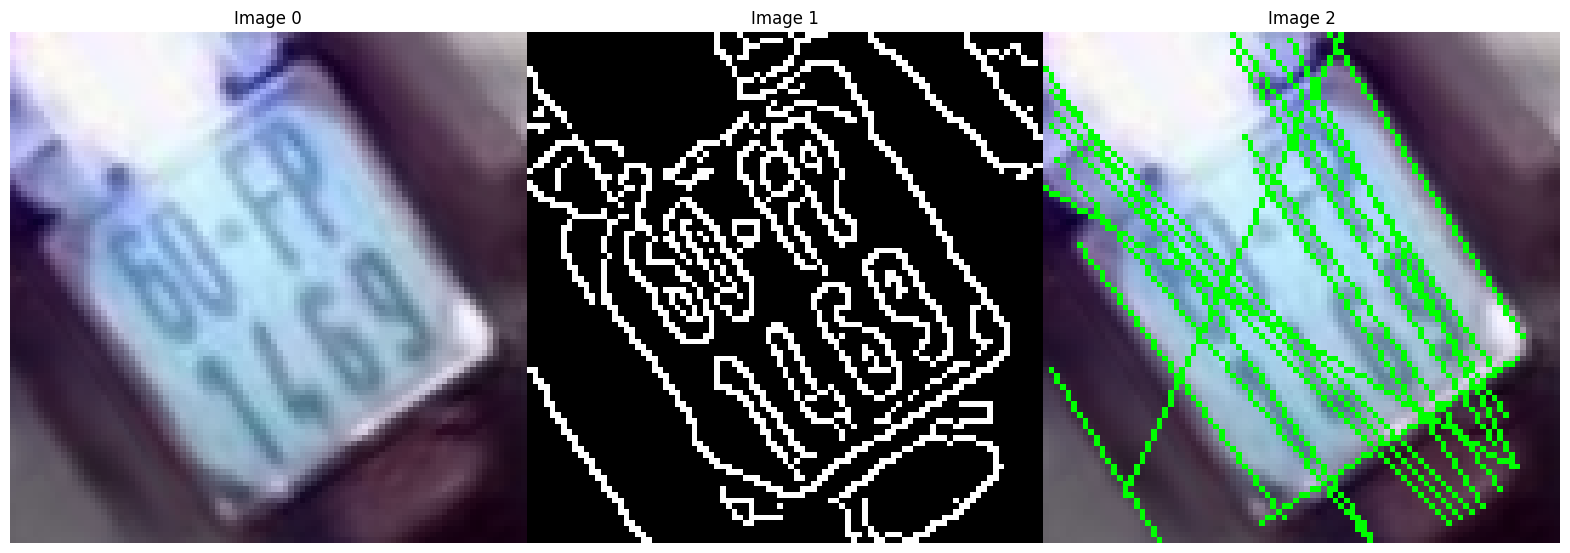

In [7]:
img_copy = img1.copy()
w, h = img_copy.shape[:2]
img = cv2.medianBlur(img1, 3)
edges = cv2.Canny(img,  threshold1 = 30,  threshold2 = 100, apertureSize = 3, L2gradient = True)
lines = cv2.HoughLinesP(edges, 1, math.pi/180, 30, minLineLength=w / 3.0, maxLineGap=h/3.0)
if lines is None:
    print('No lines found')
else:
    # vẽ đường thẳng lên hình nếu phát hiện đoạn thẳng 
    for i in range (len(lines)):
        for x1, y1, x2, y2 in lines[i]:
            cv2.line(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 1)


ShowImage([img1, edges, img_copy], nRows=1, nCols=3)

In [7]:
print(len(lines))
cnt = 0
for i in range (len(lines)):
    for x1, y1, x2, y2 in lines[i]:
        cnt += 1
print(cnt)

16
16


mục đích của detect các đoạn thẳng trong hình là để tính được góc xoay ảnh về trạng thái thẳng, model yolo ko đọc được kí tự trong ảnh nghiêng 

In [8]:
def compute_skew(src_img, center_thres):
    # kiểm tra số kênh màu của ảnh
    if len(src_img.shape) == 3:
        h, w, _ = src_img.shape
    elif len(src_img.shape) == 2:
        h, w = src_img.shape
    else:
        print('upsupported image type')

    # xử lí ảnh để tìm đường thẳng
    img = cv2.medianBlur(src_img, 3)
    edges = cv2.Canny(img,  threshold1 = 30,  threshold2 = 100, apertureSize = 3, L2gradient = True)
    lines = cv2.HoughLinesP(edges, 1, math.pi/180, 30, minLineLength=w / 3.0, maxLineGap=h/3.0)
    if lines is None:
        return 1

    # tìm đường thẳng có tọa độ y nhỏ nhất
    min_line = 100
    min_line_pos = 0 # id của đường thẳng có tọa độ y nhỏ nhất
    for i in range (len(lines)):
        for x1, y1, x2, y2 in lines[i]:
            center_point = [((x1+x2)/2), ((y1+y2)/2)] # tìm tọa độ trung điểm của đoạn thẳng
            
            # nếu center_thres = 1 thì chỉ xét các đoạn thẳng nằm ở giữa ảnh
            # nghĩa là loại bỏ các đoạn thẳng biên của ảnh
            if center_thres == 1: 
                if center_point[1] < 7:
                    continue

            # nếu y nhỏ hơn min_line thì cập nhật min_line và min_line_pos
            if center_point[1] < min_line:
                min_line = center_point[1]
                min_line_pos = i

    angle = 0.0
    cnt = 0
    for x1, y1, x2, y2 in lines[min_line_pos]:
        ang = np.arctan2(y2 - y1, x2 - x1) # tính góc nghiêng 
        if math.fabs(ang) <= 45: # excluding extreme rotations
            angle += ang
            cnt += 1
    if cnt == 0:
        return 0.0
    return (angle / cnt)*180/math.pi # trả về góc nghiêng trung bình tính bằng radian

In [41]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2) # tìm tâm ảnh
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0) # tạo ma trận xoay ảnh
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR) # xoay ảnh
    return result


def deskew(src_img, change_cons, center_thres):
    # kiem tra shape cua anh dau vao w,h co nho hon 120 khong
    if src_img.shape[0] < 120 or src_img.shape[1] < 120:
        extraa = max(120 - src_img.shape[0], 120 - src_img.shape[1])
        # resize anh de co chieu dai va chieu rong lon hon 120
        src_img = cv2.resize(src_img, (src_img.shape[1] + extraa, src_img.shape[0] + extraa))


    if change_cons == 1:
        return rotate_image(src_img, compute_skew(changeContrast(src_img), center_thres))
    else:
        return rotate_image(src_img, compute_skew(src_img, center_thres))

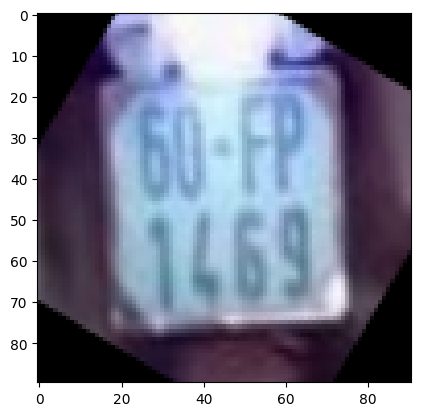

In [10]:
image_rotated = deskew(img1, 1, 1)
plt.imshow(image_rotated)

### ví dụ 1 cái hình độ phân giải thấp

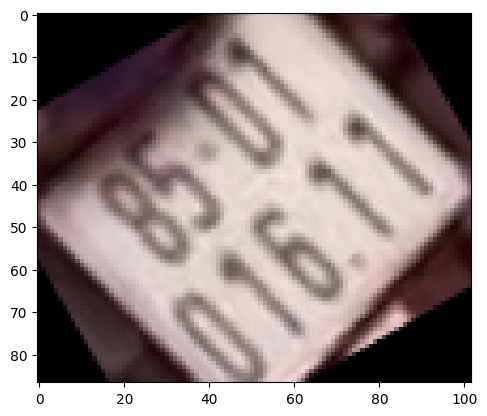

In [15]:
imgg = rotate_image(img1, 30)
plt.imshow(imgg)

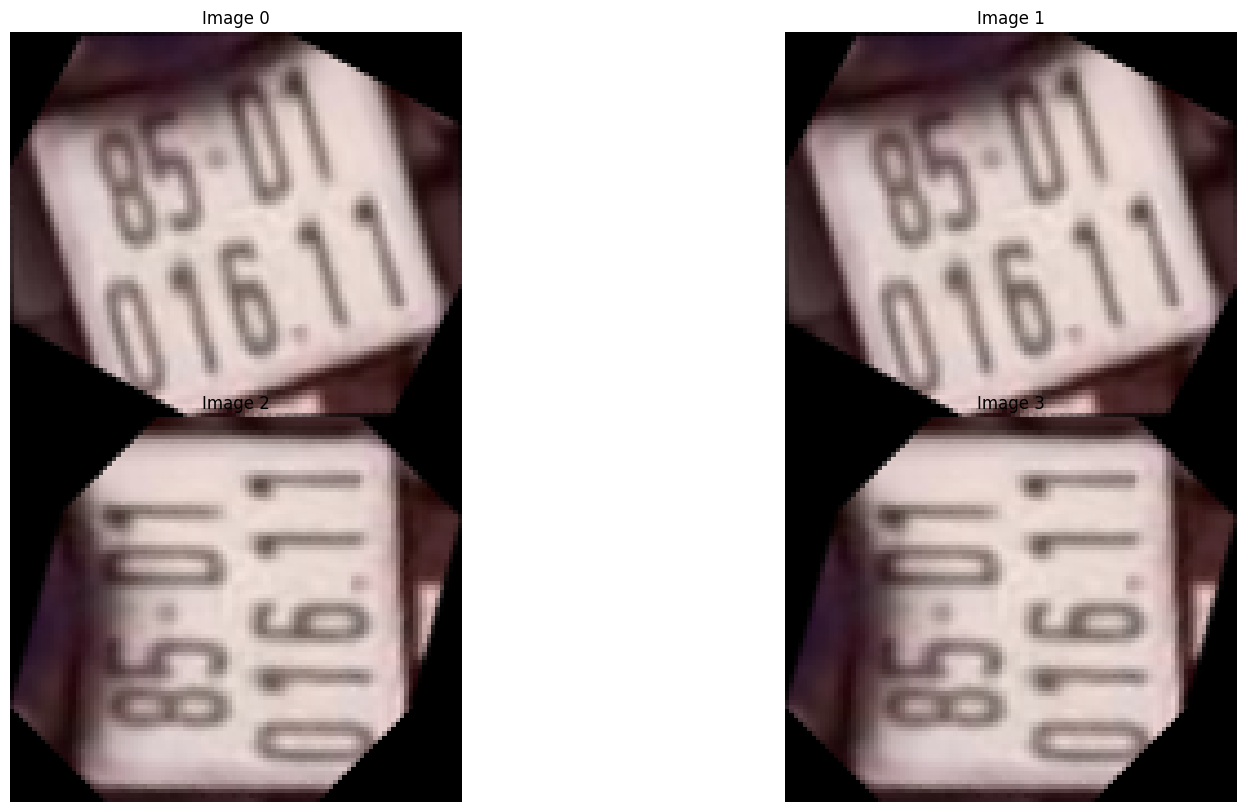

In [ ]:
img_list = []

for cc in range(0,2):
    for ct in range(0,2):
        img_list.append(deskew(imgg, cc, ct))

ShowImage(img_list, nRows=2, nCols=2)

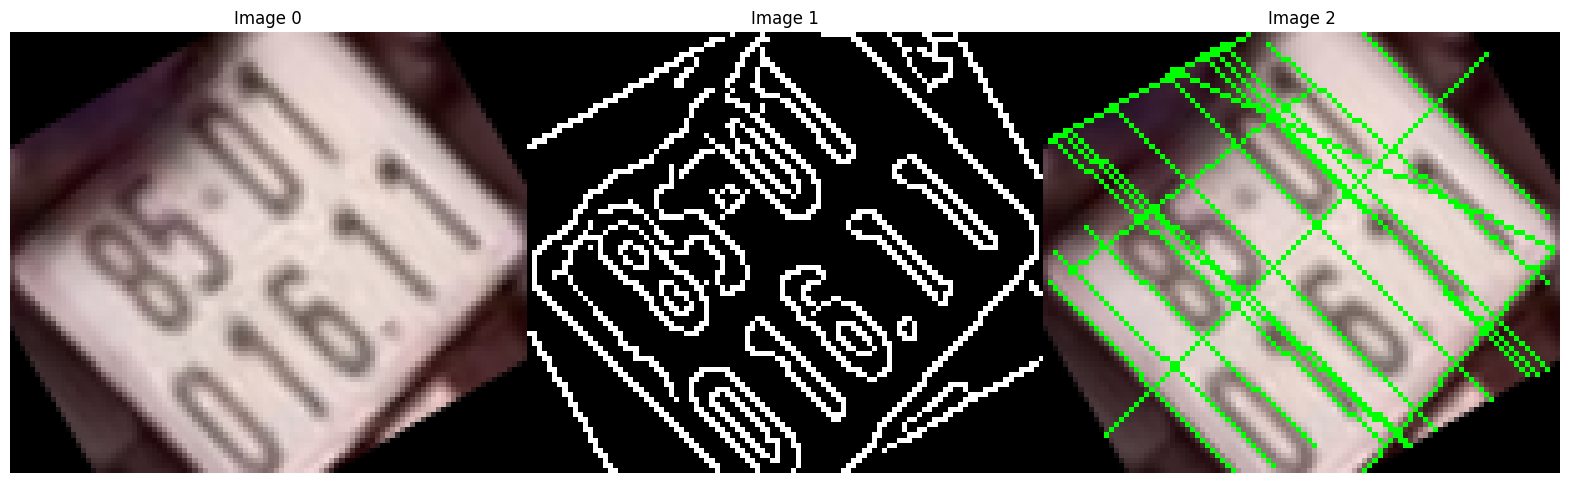

In [17]:
img_copy = imgg.copy()
w, h = img_copy.shape[:2]
img = cv2.medianBlur(img_copy, 3)
edges = cv2.Canny(img,  threshold1 = 30,  threshold2 = 100, apertureSize = 3, L2gradient = True)
lines = cv2.HoughLinesP(edges, 1, math.pi/180, 30, minLineLength=w / 3, maxLineGap=h/3.0)
if lines is None:
    print('No lines found')
else:
    # vẽ đường thẳng lên hình nếu phát hiện đoạn thẳng 
    for i in range (len(lines)):
        for x1, y1, x2, y2 in lines[i]:
            cv2.line(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 1)


ShowImage([imgg, edges, img_copy], nRows=1, nCols=3)

###

số lượng kí tự detect được phải 7 <= x <= 10        
tính tọa độ điểm trung tâm của các kí tự detect được dựa trên bounding box của nó           
tìm 2 điểm trái nhất và phải nhất dựa trên tọa độ điểm trung tâm, vẽ đường thẳng qua 2 điểm đó, xét tọa độ của các điểm khác có nằm trên đó không để xác định là biển số 1 dòng hay 2 dòng      
sắp xếp thứ tự các kí tự dựa trên tọa độ x, chuyển về chuỗi

In [30]:
def linear_equation(x1, y1, x2, y2):
    """
    Tính hệ số góc và hệ số tự do của phương trình đường thẳng đi qua 2 điểm (x1, y1) và (x2, y2)
    """
    b = y1 - (y2 - y1) * x1 / (x2 - x1)
    a = (y1 - b) / x1
    return a, b

def check_point_linear(x, y, x1, y1, x2, y2):
    """
    Kiểm tra điểm (x, y) có nằm trên đường thẳng đi qua 2 điểm (x1, y1) và (x2, y2) hay không
    """
    a, b = linear_equation(x1, y1, x2, y2)
    y_pred = a*x+b
    return(math.isclose(y_pred, y, abs_tol = 3))

def read_plate(yolo_license_plate, im):
    im = changeContrast(im)
    LP_type = "1"
    results = yolo_license_plate(im)
    bb_list = results.pandas().xyxy[0].values.tolist()
    if len(bb_list) == 0 or len(bb_list) < 7 or len(bb_list) > 10:
        return "unknown" #len(bb_list)
    center_list = []
    y_mean = 0
    y_sum = 0
    # find center of each bounding box
    for bb in bb_list:
        x_c = (bb[0]+bb[2])/2
        y_c = (bb[1]+bb[3])/2
        y_sum += y_c
        center_list.append([x_c,y_c,bb[-1]]) # bb[-1] là kí tự nhận diện được
    # find 2 point to draw line
    l_point = center_list[0]
    r_point = center_list[0]
    for cp in center_list:
        # tìm điểm trái nhất và phải nhất
        if cp[0] < l_point[0]:
            l_point = cp
        if cp[0] > r_point[0]:
            r_point = cp
    for ct in center_list:
        if l_point[0] != r_point[0]:
            # nếu có 1 điểm không nằm trên đường thẳng thì là biển số 2 dòng
            if (check_point_linear(ct[0], ct[1], l_point[0], l_point[1], r_point[0], r_point[1]) == False):
                LP_type = "2"

    y_mean = int(int(y_sum) / len(bb_list)) # đường giữa 2 dòng
    # size = results.pandas().s

    # 1 line plates and 2 line plates
    line_1 = []
    line_2 = []
    license_plate = ""
    if LP_type == "2":
        for c in center_list:
            if int(c[1]) > y_mean:
                line_2.append(c)
            else:
                line_1.append(c)
        # sort the list of center points by x coordinate
        for l1 in sorted(line_1, key = lambda x: x[0]):
            license_plate += str(l1[2])
        license_plate += "-"
        for l2 in sorted(line_2, key = lambda x: x[0]):
            license_plate += str(l2[2])
    else:
        for l in sorted(center_list, key = lambda x: x[0]):
            license_plate += str(l[2])
    return license_plate

In [12]:
# load yolo model for detect and character detection stage
# please download yolov5 from our link on github
yolo_LP_detect = torch.hub.load('yolov5', 'custom', path='model/LP_detector.pt', force_reload=True, source='local')
yolo_license_plate = torch.hub.load('yolov5', 'custom', path='model/LP_ocr.pt', force_reload=True, source='local')

# set model confidence threshold 
# yolo_LP_detect.conf = 0.6
yolo_license_plate.conf = 0.60

YOLOv5  v7.0-385-gb968b2d7 Python-3.12.3 torch-2.5.1 CPU

Fusing layers... 
Model summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
YOLOv5  v7.0-385-gb968b2d7 Python-3.12.3 torch-2.5.1 CPU

Fusing layers... 
Model summary: 290 layers, 20970123 parameters, 0 gradients, 48.2 GFLOPs
Adding AutoShape... 


In [34]:
#enter image path here
img_file = "test_image/557.png"
img = cv2.imread(img_file)
plates = yolo_LP_detect(img, size=640)

d:\THUCHANH\License-Plate-Recognition\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [40]:
list_plates = plates.pandas().xyxy[0].values.tolist()
list_read_plates = set()
cnt = 0
if len(list_plates) == 0:
    lp = read_plate(yolo_license_plate, img)
    if lp != "unknown":
        cv2.putText(img, lp, (7, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        list_read_plates.add(lp)
else:
    for plate in list_plates:
        flag = 0
        x = int(plate[0]) # xmin
        y = int(plate[1]) # ymin
        w = int(plate[2] - plate[0]) # xmax - xmin
        h = int(plate[3] - plate[1]) # ymax - ymin  
        crop_img = img[y:y+h, x:x+w]
        cv2.rectangle(img, (int(plate[0]),int(plate[1])), (int(plate[2]),int(plate[3])), color = (0,0,225), thickness = 2)
        cv2.imwrite("crop.jpg", crop_img)
        rc_image = cv2.imread("crop.jpg")
        lp = ""
        # thử hết các trường hợp xoay ảnh và tăng tương phản
        for cc in range(0,2):
            for ct in range(0,2):
                lp = read_plate(yolo_license_plate, deskew(crop_img, cc, ct))
                if lp != "unknown":
                    list_read_plates.add(lp)
                    cv2.putText(img, lp, (int(plate[0]), int(plate[1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
                    flag = 1
                    break
                else:
                    cnt += 1
            if flag == 1:
                break      

d:\THUCHANH\License-Plate-Recognition\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
d:\THUCHANH\License-Plate-Recognition\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
d:\THUCHANH\License-Plate-Recognition\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
d:\THUCHANH\License-Plate-Recognition\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
d:\THUCHANH\License-Plate-Recognition\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)`

In [16]:
cnt

0

{'75H1-4299', '75A-18283', '715B1-18', '75H1-42599', '75H1-36121'}


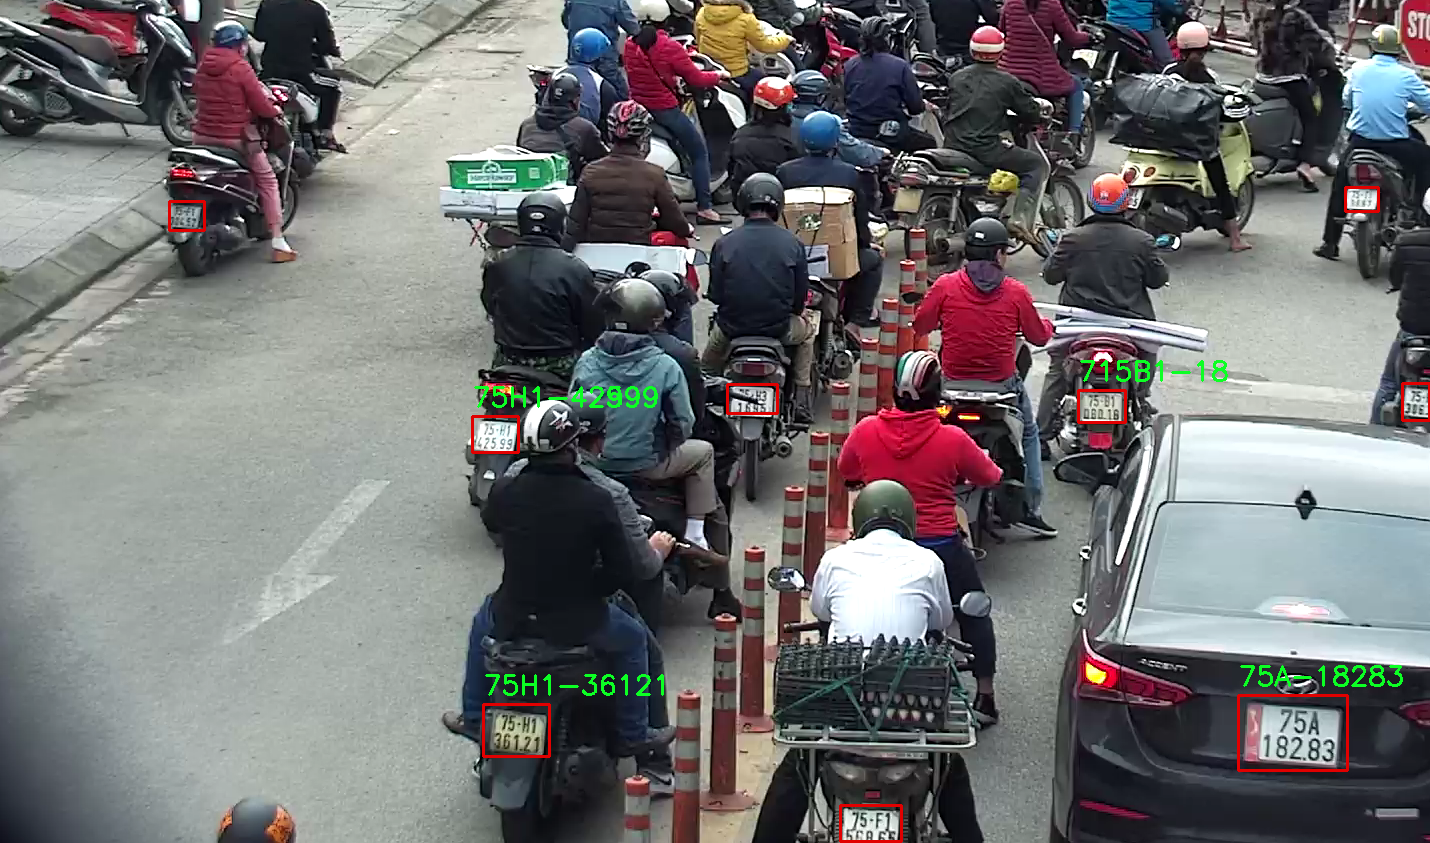

In [39]:
print(list_read_plates)
# display image
display(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))

In [17]:
image_rotated_contrast = changeContrast(image_rotated)

In [18]:
lp = read_plate(yolo_license_plate, image_rotated_contrast)
lp

d:\THUCHANH\License-Plate-Recognition\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


'60FP-1469'

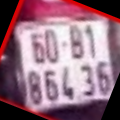

In [28]:
crop_image = cv2.imread("crop.jpg")
crop_image = cv2.resize(crop_image, (120, 120))
crop_image_rotated = deskew(crop_image, 1, 1)
display(Image.fromarray(cv2.cvtColor(crop_image_rotated, cv2.COLOR_BGR2RGB)))

In [18]:
# show img in cv2 window
# cv2.imshow('frame', img)
# cv2.waitKey()
# cv2.destroyAllWindows()    